In [1]:
import math
import pathlib
import re

import rosbag
import geometry_msgs.msg as geomsg

import cameratransform as ct
from tf.transformations import quaternion_from_euler, euler_from_quaternion
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import numpy as np
import cv2

from cv_bridge import CvBridge

import torch
import torchvision
import av
import postprocess

In [2]:
!ls ..

GazeboRosPkgs		     database_generator_record_2021-06-03-14-23-08.bag
Models			     gazebo_actor-updaterate_patch.sh
NRPExp_DVSDatabaseGenerator  nrp_installer.sh
README.md		     pkgs.txt
Scripts_deprecated	     record.bag
TODO.md			     src


In [190]:
bag = rosbag.Bag("../record.bag")
model_topic = "/gazebo/model_states"
camera_topic = "/robot/camera_rgb_00"
event_topic = "/robot/camera_dvs_00/events"
bridge = CvBridge()
g = postprocess.process_bag(bag, bridge, model_topic, camera_topic, event_topic)

In [4]:
# for topic, msg, t in bag.read_messages(topics=["/gazebo/link_states"]):
#     d = {n: i for i, n in enumerate(msg.name)}
#     i = d["animated camera::eye_vision_camera"]
#     print(msg.pose[i])

In [10]:
# for topic, msg, t in bag.read_messages(topics=["/robot/camera_dvs_00/events"]):
#     dvs_img = np.zeros((512, 512, 3), dtype=np.uint8)
#     for event in msg.events:
#         dvs_img[event.y][event.x] = (event.polarity*255, 255, 0)
#     plt.imshow(dvs_img)
#     plt.show()
def events_to_image(msg):
    dvs_img = np.zeros((512, 512, 3), dtype=np.uint8)
    for event in msg.events:
        dvs_img[event.y][event.x] = (event.polarity*255, 255, 0)
    return dvs_img

In [66]:
def image_labels(camera, tool_poses, tool_meshes):
    images = []

    for tool_class, (tool, pose) in enumerate(tool_poses.items()):
        raw_vertices, raw_triangles = tool_meshes[tool]
        transformed = transform_tool(raw_vertices, pose)
        projection = camera.imageFromSpace(transformed)
        triangles = np.take(projection, raw_triangles, axis=0).astype(int)
        image_class = np.zeros((512, 512))
        for mesh in triangles:
            cv2.fillConvexPoly(image_class, mesh, tool_class + 1)
        images.append(image_class)
    return images

In [191]:
out = next(g)

In [95]:
def transform_tool(mesh, pose):
    orientation = pose.orientation
    orientation_quat = np.array(
        [orientation.x, orientation.y, orientation.z, orientation.w]
    )
    rotation = Rotation.from_quat(orientation_quat)
    rotation_corrected = rotation.as_euler('xyz')# + np.array([0, -0.08, -0.08])
    rotation = Rotation.from_euler('xyz', rotation_corrected)
    position = np.array([pose.position.x, pose.position.y, pose.position.z])
    return position + rotation.apply(mesh)

In [112]:
ct.SpatialOrientation?

1.470728869875 1.51387025128125 1.02227728953125 -5.729577951308232 5.729577951308231 -133.7824055584749 [-0.1         0.1        -2.33494346]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


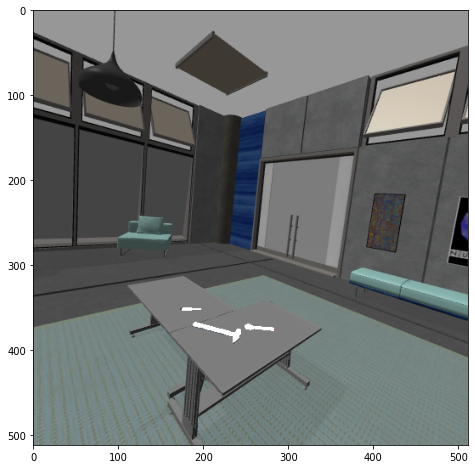

(0.0,
 3.0,
 0.00342559814453125,
 (rospy.Time[41000000], rospy.Time[35000000], rospy.Time[39000000]))

In [203]:
plt.figure(figsize=(16, 8))
(image, camera_pose, tool_poses, tool_meshes, times) = out
(x, y, z, roll, pitch, yaw) = camera_pose
(roll, pitch, yaw) = (radians * 180 / np.pi for radians in (roll, pitch, yaw))
projection = ct.RectilinearProjection(
    focallength_px=0.5003983220157445 * 512, image=(512, 512)
)
orientation = ct.SpatialOrientation(
    pos_x_m=x + 0.045, pos_y_m=y - 0.08, elevation_m=z + 1.0,
    roll_deg=roll+11, tilt_deg=90-pitch, heading_deg=90-yaw,
)
camera = ct.Camera(projection, orientation)
print(x, y, z, roll, pitch, yaw, camera_pose[3:])

images = image_labels(camera, tool_poses, tool_meshes)
cl = images[0] + images[1] + images[2]
cl = np.broadcast_to(np.expand_dims(cl, 2), (512, 512, 3))
plt.imshow(image / 300 + cl)
plt.show()
cl.min(), cl.max(), cl.mean(), times

In [55]:
rr =np.array([0, 0.78, 0.78]) - r.as_euler('xyz')
Rotation.from_euler('xyz', rr)

1.470728869875 1.51387025128125 1.02227728953125 -5.729577951308232 5.729577951308231 -133.7824055584749 [-0.1         0.1        -2.33494346]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


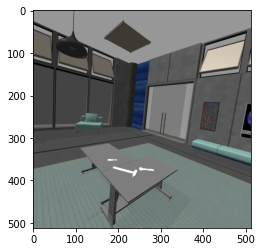

1.442116125 1.52621784375 1.04074109375 -5.729577951308232 5.729577951308231 -132.9622759486953 [-0.1        0.1       -2.3206295]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


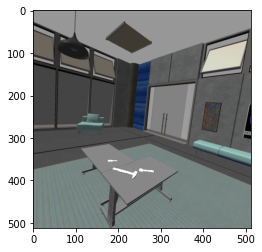

1.417007127375 1.53628943690625 1.05488698015625 -5.729577951308231 5.729577951308234 -132.256583110099 [-0.1         0.1        -2.30831283]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


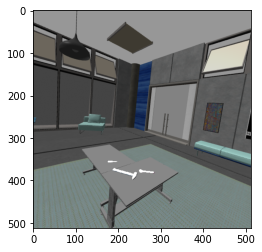

1.388389641 1.54706246475 1.06914005875 -5.729577951308232 5.729577951308229 -131.46467117927244 [-0.1         0.1        -2.29449136]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


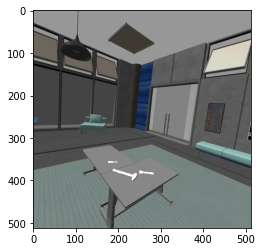

1.363453125 1.55593359375 1.08021484375 -5.729577951308235 5.729577951308229 -130.7832836493029 [-0.1         0.1        -2.28259891]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


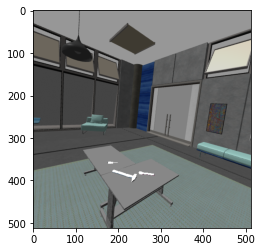

1.326248064 1.568415984 1.09481336 -5.729577951308232 5.729577951308231 -129.77862835518206 [-0.1         0.1        -2.26506436]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


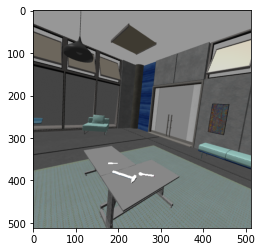

1.295186599125 1.57824431896875 1.10551717671875 -5.729577951308234 5.729577951308231 -128.9487358539707 [-0.1         0.1        -2.25058001]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


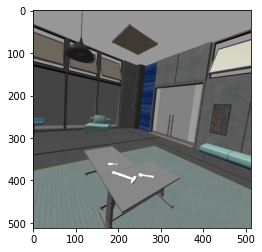

1.2554695439999999 1.590138114 1.11755981 -5.729577951308234 5.729577951308231 -127.89691213673949 [-0.1         0.1        -2.23222222]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


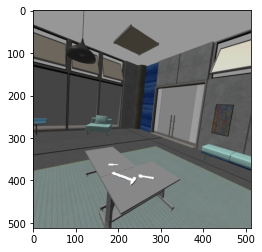

1.219034781375 1.60046752340625 1.12722350265625 -5.729577951308235 5.729577951308232 -126.93942489058496 [-0.1         0.1        -2.21551091]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


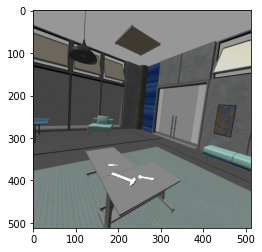

1.1825504628749999 1.61031835303125 1.13576045328125 -5.729577951308235 5.729577951308232 -125.98633496866951 [-0.1         0.1        -2.19887636]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


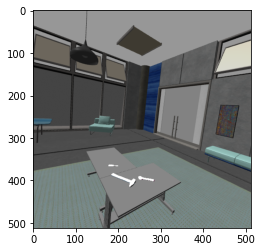

1.142093134125 1.62072518521875 1.14406573296875 -5.729577951308235 5.729577951308231 -124.93482201106974 [-0.1         0.1        -2.18052399]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


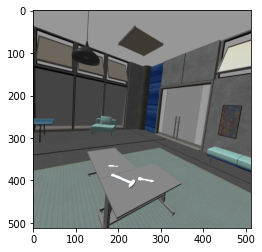

1.103109479625 1.63028734884375 1.15105379359375 -5.729577951308234 5.729577951308232 -123.92587795854334 [-0.1        0.1       -2.1629146]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


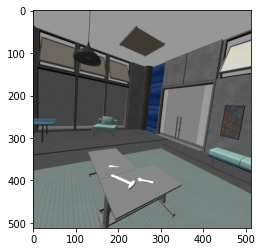

1.060087825875 1.64035651228125 1.15774685453125 -5.729577951308235 5.72957795130823 -122.81623429300747 [-0.1         0.1        -2.14354766]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


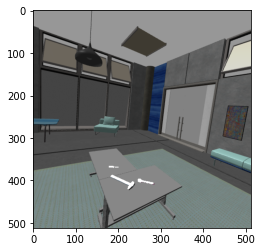

1.018816767375 1.64957702690625 1.16327433015625 -5.729577951308232 5.729577951308232 -121.75463371627797 [-0.1         0.1        -2.12501924]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


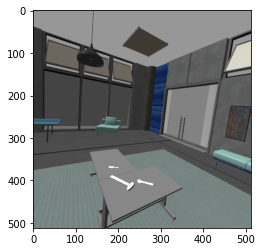

0.973457858625 1.65925175409375 1.16844978484375 -5.729577951308235 5.729577951308232 -120.59028534967157 [-0.1         0.1        -2.10469753]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


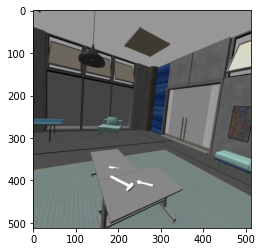

0.930111328125 1.66807763671875 1.17260498046875 -5.729577951308234 5.729577951308231 -119.47922585514686 [-0.1         0.1        -2.08530588]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


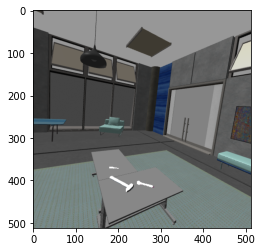

0.884241024 1.676997744 1.17624376 -5.729577951308235 5.729577951308231 -118.30453044665458 [-0.1         0.1        -2.06480358]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


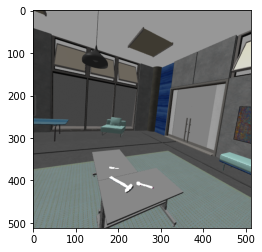

0.837432163875 1.68567942778125 1.17922866203125 -5.729577951308232 5.729577951308231 -117.1062779884234 [-0.1         0.1        -2.04389013]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


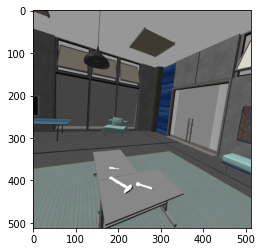

0.7980231348749999 1.6926741850312501 1.18122073328125 -5.729577951308231 5.729577951308234 -116.09739608548846 [-0.1         0.1        -2.02628181]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


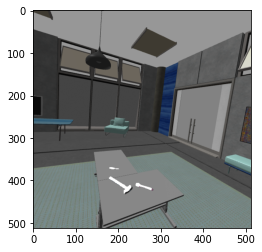

0.7513224843749998 1.70060609765625 1.18301587890625 -5.729577951308232 5.729577951308231 -114.90131815686004 [-0.1         0.1        -2.00540632]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


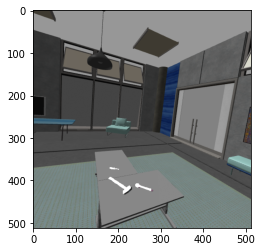

0.702182829 1.70854916775 1.18429555375 -5.729577951308232 5.729577951308229 -113.64165430125068 [-0.1         0.1        -1.98342103]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


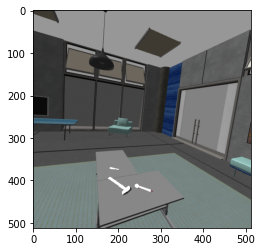

0.650580744 1.7164603139999999 1.18502281 -5.729577951308235 5.729577951308232 -112.31707906574232 [-0.1         0.1        -1.96030284]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


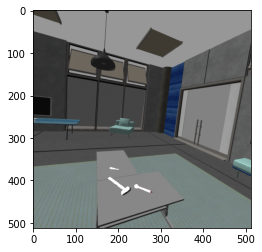

0.601767168 1.723550208 1.18517632 -5.729577951308235 5.729577951308231 -111.06190491135469 [-0.1         0.1        -1.93839591]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


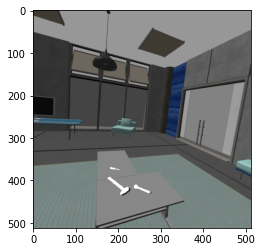

0.5488261529999998 1.73081733675 1.18480193875 -5.729577951308235 5.729577951308234 -109.69768759116751 [-0.1         0.1        -1.91458583]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


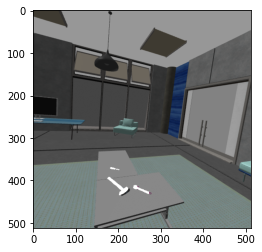

0.5006615583749998 1.73705432915625 1.18400882640625 -5.729577951308234 5.729577951308232 -108.45348391289667 [-0.1         0.1        -1.89287038]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


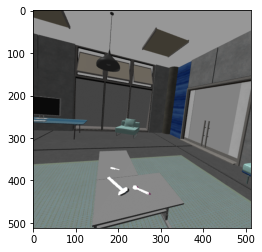

0.44843531699999994 1.74342004575 1.18269742375 -5.729577951308231 5.729577951308234 -107.1005928923761 [-0.1         0.1        -1.86925798]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


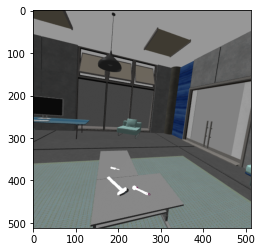

0.39939810937499987 1.74902469140625 1.18106822265625 -5.729577951308232 5.72957795130823 -105.82633023873429 [-0.1        0.1       -1.8470179]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


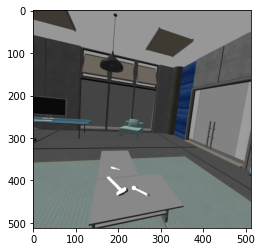

0.34450064062499974 1.75487405859375 1.17881927734375 -5.729577951308232 5.729577951308232 -104.39471878725894 [-0.1         0.1        -1.82203156]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


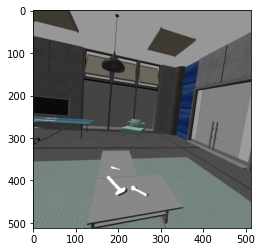

0.294770883 1.75978615425 1.17642057625 -5.729577951308234 5.729577951308232 -103.09281226645288 [-0.1         0.1        -1.79930901]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


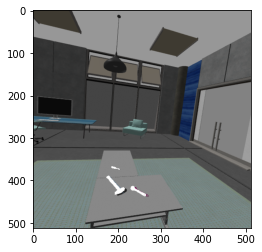

0.23549985899999992 1.76515991025 1.1731443162500002 -5.729577951308235 5.729577951308231 -101.53425497481764 [-0.1         0.1        -1.77210705]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


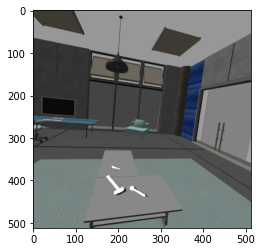

KeyboardInterrupt: 

In [182]:
for image, camera_pose, tool_poses, tool_meshes, times in g:
    (x, y, z, roll, pitch, yaw) = camera_pose
    (roll, pitch, yaw) = (radians * 180 / np.pi for radians in (roll, pitch, yaw))
    projection = ct.RectilinearProjection(
        focallength_px=0.5003983220157445 * 512, image=(512, 512)
    )
    orientation = ct.SpatialOrientation(
        pos_x_m=x + 0.04, pos_y_m=y - 0.08, elevation_m=z + 1.0,
        roll_deg=roll+11, tilt_deg=90-pitch, heading_deg=90-yaw,
    )
    camera = ct.Camera(projection, orientation)
    print(x, y, z, roll, pitch, yaw, camera_pose[3:])

    images = image_labels(camera, tool_poses, tool_meshes)
    cl = images[0] + images[1] + images[2]
    cl = np.broadcast_to(np.expand_dims(cl, 2), (512, 512, 3))
    plt.imshow(image / 300 + cl)
    plt.show()
    cl.min(), cl.max(), cl.mean(), times

In [ ]:
images = []
events = []
labels = []
count = 0
for _, image, event, label in g:
    images.append(image)
    events.append(event)
    labels.append(label)
    count += 1
    #if count > 100:
    #    break 

In [ ]:
len(images)

In [ ]:
torch_images = torch.stack([torch.tensor(x) for x in images])
torch_labels = torch.stack([torch.tensor(x) for x in labels])

In [ ]:
torchvision.io.write_video("h.mp4", torch_labels, fps=20)